# Modelamiento

In [1]:
import sys
import os
import tensorflow as tf
import keras_tuner
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='keras')

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.MLDS6_Assets.database import deleteDirectoryAndContents
from src.MLDS6_Assets.preprocessing import countFilesinFolder
from src.MLDS6_Assets.visualization import plotDataPartition
from src.MLDS6_Assets.models import trainTestSplitImages, loadImagesFromDirectory, loadTestImagesFromDirectory, loadAndAugmentImagesFromDirectory, configModelV1, configModelV2, getModelTestResults
from src.MLDS6_Assets.models.training import trainModel, plotTrainingHistory

## Partición de datos

Para la partición de datos, vamos a tomar de base los datos unidos y balanceados en un único dataset. Para realizar la partición, usaremos la función train test split de sklearn y mantener el esquema de carpetas

In [2]:
trainTestSplitImages('../data',
                    '../splitData/temp',
                    '../splitData/test',
                    test_size = 0.1,
                    random_state = 42)

Split from 
../data
to
../splitData/temp
and
../splitData/test
was done successfully


In [3]:
trainTestSplitImages('../splitData/temp',
                    '../splitData/train',
                    '../splitData/val',
                    test_size = 1/9,
                    random_state = 42)

Split from 
../splitData/temp
to
../splitData/train
and
../splitData/val
was done successfully


In [4]:
deleteDirectoryAndContents('../data')
deleteDirectoryAndContents('../splitData/temp')
os.rename('../splitData','../data')

Deleted directory and all contents: ../data
Deleted directory and all contents: ../splitData/temp


Verificamos que las clases esten balanceados

In [5]:
dirs = [
  '../data/train/Normal',
  '../data/test/Normal',
  '../data/val/Normal',
  '../data/train/bacterialPneumonia',
  '../data/test/bacterialPneumonia',
  '../data/val/bacterialPneumonia',
  '../data/train/virusPneumonia',
  '../data/test/virusPneumonia',
  '../data/val/virusPneumonia'
]

s = {}
for dir in dirs:
  keys = dir.split('/')[2:]
  if keys[0] not in s: s[keys[0]] = {}
  if keys[1] not in s[keys[0]]: s[keys[0]][keys[1]] = countFilesinFolder(dir)

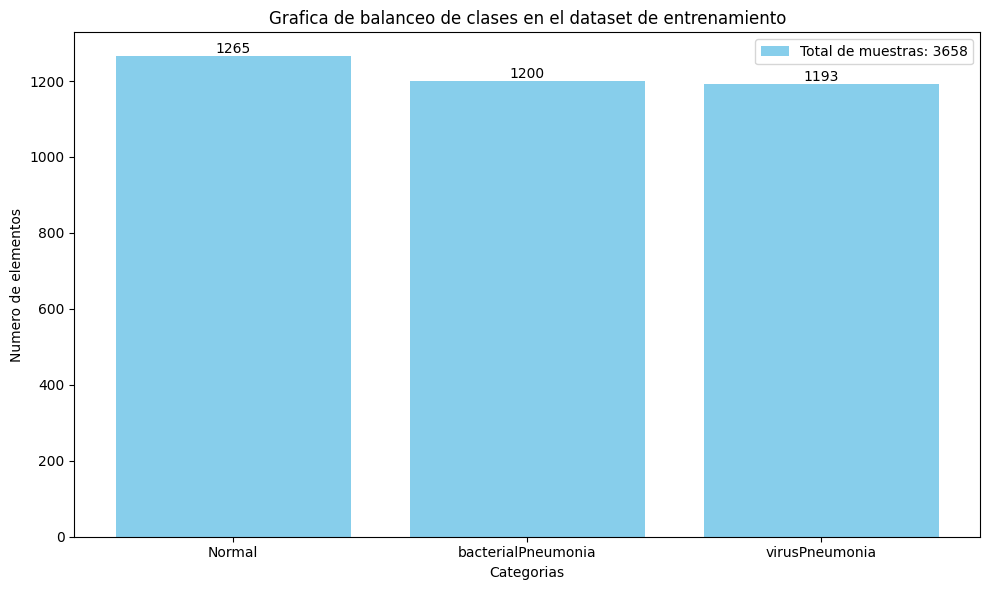

In [6]:
plotDataPartition(s['train'], 'Grafica de balanceo de clases en el dataset de entrenamiento')

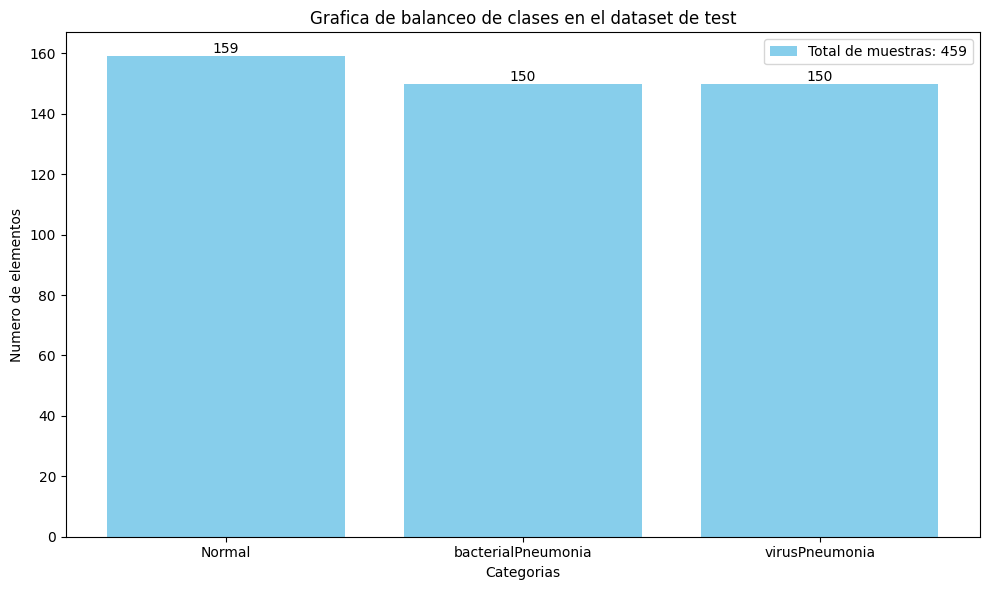

In [7]:
plotDataPartition(s['test'], 'Grafica de balanceo de clases en el dataset de test')

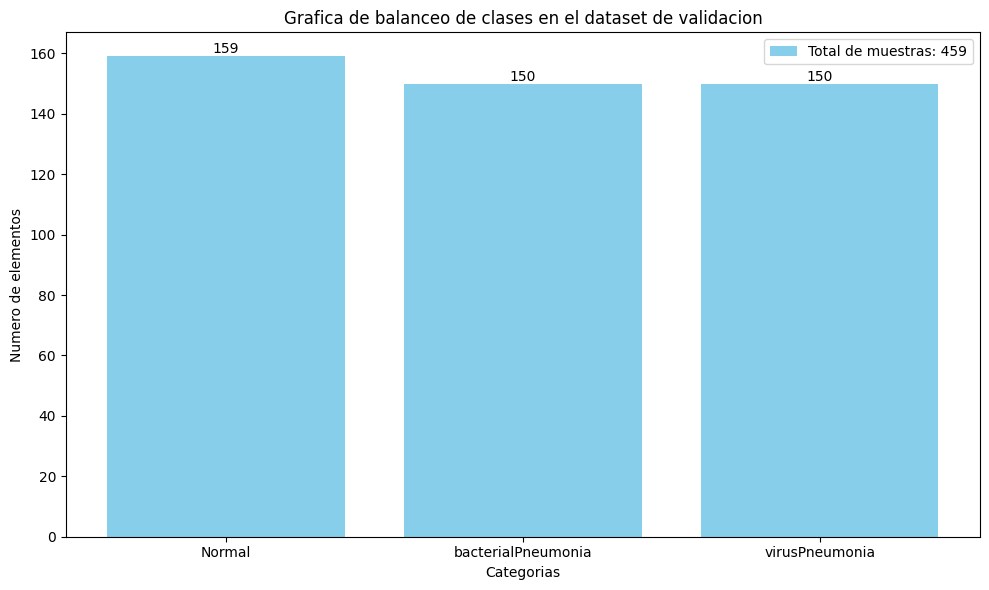

In [8]:
plotDataPartition(s['val'], 'Grafica de balanceo de clases en el dataset de validacion')

## Carga de datos

Dado que los datos se encuentran en el sistema de carpetas que maneja el dispositivo, se buscará cargarlos a objetos de tipo dataset de Keras

In [2]:
train = '../data/train'
val = '../data/val'
test = '../data/test'
batch_size = 32
train_dataset = loadAndAugmentImagesFromDirectory(train, batch_size)
val_dataset = loadImagesFromDirectory(val, batch_size)
test_dataset , classNames = loadTestImagesFromDirectory(test, batch_size)

train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

Found 3658 files belonging to 3 classes.
Found 459 files belonging to 3 classes.
Found 459 files belonging to 3 classes.


## Selección y Diseño de modelos

Para abordar el problema de clasificación de imágenes en el diagnóstico de neumonía a partir de radiografías, hemos seleccionado los modelos VGG16 y EfficientNetB0 junto con 2 configuraciones distintas en la arquitectura para realizar de esta manera en princpio 4 versiones posibles y comparar resultados. El proceso implica implementar transfer learning utilizando modelos preentrenados, lo que permitirá aprovechar características previamente aprendidas en grandes conjuntos de datos, acelerando el entrenamiento y mejorando la generalización en nuestro conjunto de datos específico. 

Es importante destacar que se utilizo un proceso de busqueda de hiperparametros (en este caso cambio en la cantidad de hidden units en las capas de las redes neuronales) dando como resultado un entrenamiento aproximado de 10 modelos, de los cuales se seleccionaron en cada arquitectura y configuracion los mejores, es decir, las 4 mejores versiones de cada arquitectura y configuracion. 

Teniendo en cuenta lo anterior, empezamos haciendo el cargado en crudo de los modelos pre entrenandos:


In [4]:
# Carga del modelo base preentrenado
model_efficientnet = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(720, 500, 3))
#Congelamos capas
for layer in model_efficientnet.layers:
    layer.trainable = False

model_VGG16 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(720, 500, 3))
#Congelamos capas
for layer in model_VGG16.layers:
    layer.trainable = False

Ahora, dada la arquitectura base la pasamos como parametro a las funciones de configuracion para configurar nuestras capas, ademas, cargamos keras_tuner para desde ya plantear una busqueda de hiperparametros en los resultados de la arquitectura.

In [3]:
# Modelos basados en VGG16

#VGG16 con la primera configuracion
model_VGG16_v1 = keras_tuner.RandomSearch(
    # hp es el termino para los hiperparametros, le pasamos el modelo a la configuracion
    lambda hp: configModelV1(model_VGG16,hp, lr=1e-1),
    objective='val_loss',
    max_trials=5)

#VGG16 con la segunda configuracion
model_VGG16_v2 = keras_tuner.RandomSearch(
    # hp es el termino para los hiperparametros, le pasamos el modelo a la configuracion
    lambda hp: configModelV2(model_VGG16,hp, lr=1e-1),
    objective='val_loss',
    max_trials=5)

# Modelos basados en EfficientNetB0_v1

#EfficientNetB0_v1 con la primera configuracion
model_EfficientNetB0_v1 = keras_tuner.RandomSearch(
    lambda hp: configModelV1(model_efficientnet,hp, lr=1e-1),
    objective='val_loss',
    max_trials=5)

#EfficientNetB0_v1 con la segunda configuracion
model_EfficientNetB0_v2 = keras_tuner.RandomSearch(
    lambda hp: configModelV2(model_efficientnet,hp, lr=1e-1),
    objective='val_loss',
    max_trials=5)

## Búsqueda de Hiperparámetros

Una vez definidas las funciones, les pasamos los valores de entrenamiento y validacion y empezamos con la busqueda de hiperparametros:

In [ ]:
model_VGG16_v1.search(
    train_dataset,
    validation_data=val_dataset,
    epochs=5
)

Trial 2 Complete [00h 46m 42s]
val_loss: 0.7336503863334656

Best val_loss So Far: 0.7336503863334656
Total elapsed time: 01h 35m 01s


In [ ]:
model_VGG16_v2.search(
    train_dataset,
    validation_data=val_dataset,
    epochs=5
)

Trial 3 Complete [00h 51m 03s]
val_loss: 0.8490365147590637

Best val_loss So Far: 0.8274023532867432
Total elapsed time: 02h 37m 08s


In [ ]:
model_EfficientNetB0_v1.search(
    train_dataset,
    validation_data=val_dataset,
    epochs=5
)

Trial 2 Complete [00h 42m 26s]
val_loss: 1.1060811281204224

Best val_loss So Far: 1.1060811281204224
Total elapsed time: 01h 26m 12s


In [ ]:
model_EfficientNetB0_v2.search(
    train_dataset,
    validation_data=val_dataset,
    epochs=5
)

Trial 3 Complete [00h 43m 32s]
val_loss: 1.113497257232666

Best val_loss So Far: 1.1020921468734741
Total elapsed time: 02h 16m 15s


Una vez terminado, vemos un pequeño resumen de la exploracion realizada:

In [ ]:
model_VGG16_v1.results_summary()

Results summary
Results in ./data
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 1 summary
Hyperparameters:
units: 256
Score: 0.7336503863334656

Trial 0 summary
Hyperparameters:
units: 128
Score: 0.7554000616073608


In [ ]:
model_EfficientNetB0_v1.results_summary()

Results summary
Results in ./data
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 1 summary
Hyperparameters:
units: 256
Score: 1.1060811281204224

Trial 0 summary
Hyperparameters:
units: 128
Score: 1.1144862174987793


In [ ]:
model_VGG16_v2.results_summary()

Results summary
Results in ./data
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 1 summary
Hyperparameters:
units: 32
Score: 0.8274023532867432

Trial 0 summary
Hyperparameters:
units: 128
Score: 0.8330350518226624

Trial 2 summary
Hyperparameters:
units: 64
Score: 0.8490365147590637


In [ ]:
model_EfficientNetB0_v2.results_summary()

Results summary
Results in ./data
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 1 summary
Hyperparameters:
units: 32
Score: 1.1020921468734741

Trial 0 summary
Hyperparameters:
units: 128
Score: 1.108487606048584

Trial 2 summary
Hyperparameters:
units: 64
Score: 1.113497257232666


## Comparación de resultados

Para comparar los resultados, se va a evaluar el desempeño de los modelos usando distintas métricas en tareas de clasificación

### Efficient Net con la primera configuración

In [ ]:
model = model_EfficientNetB0_v1.get_best_models()[0]
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 720, 500, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 23, 16, 1280)   │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,412,843 (16.83 MB)

 Trainable params: 181,379 (708.51 KB)

 Non-trainable params: 4,050,083 (15.45 MB)

 Optimizer params: 181,381 (708.52 KB)

15/15 ━━━━━━━━━━━━━━━━━━━━ 270s 18s/step


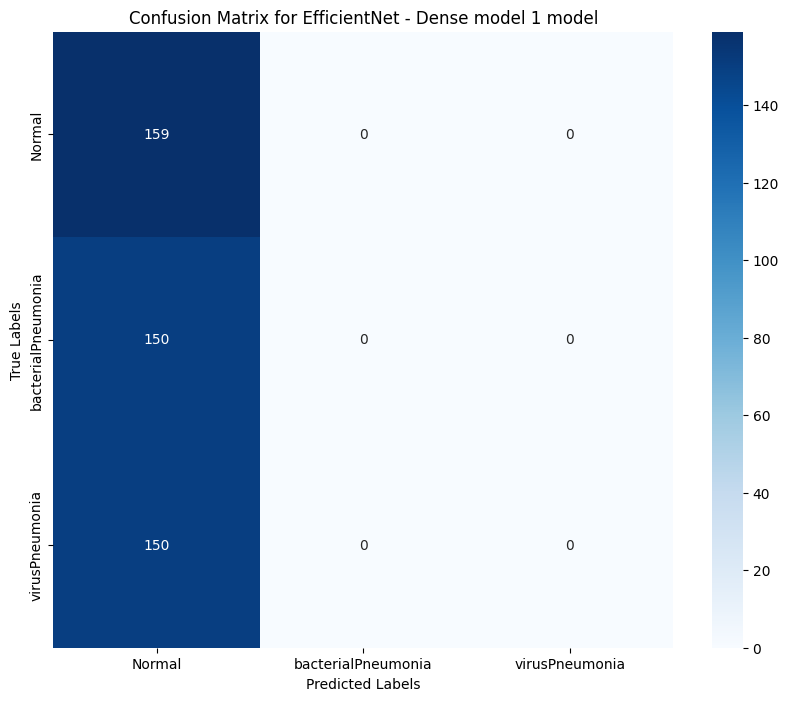


                    precision    recall  f1-score   support

            Normal       0.35      1.00      0.51       159
bacterialPneumonia       0.00      0.00      0.00       150
    virusPneumonia       0.00      0.00      0.00       150

          accuracy                           0.35       459
         macro avg       0.12      0.33      0.17       459
      weighted avg       0.12      0.35      0.18       459




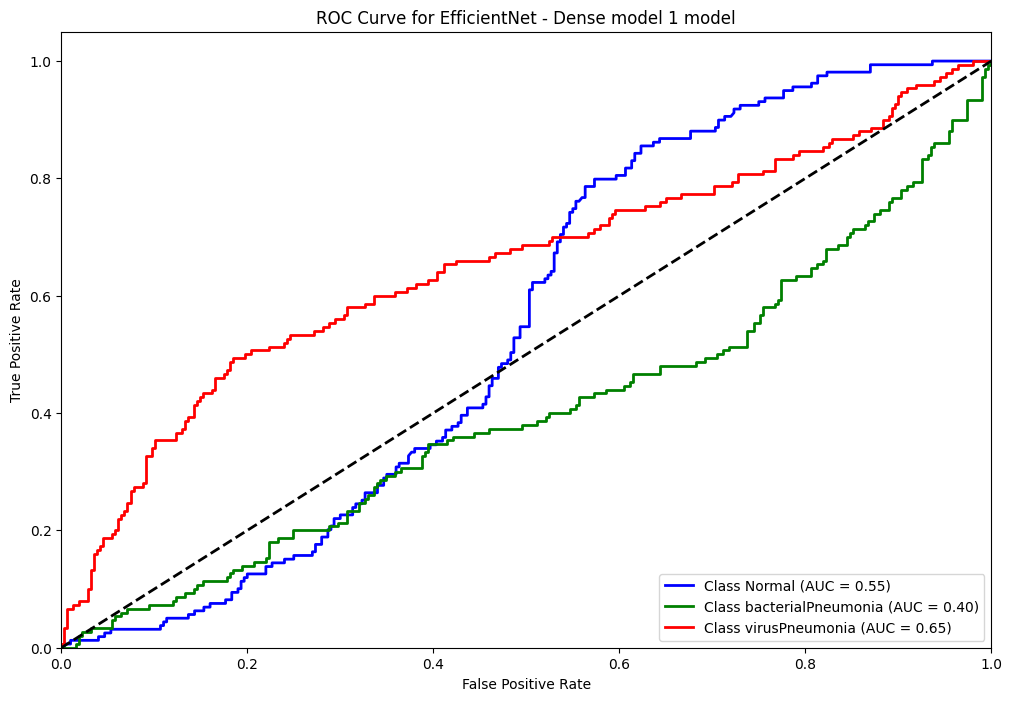

In [5]:
getModelTestResults(model,test_dataset,classNames,name="EfficientNet - Dense model 1")

### Efficient Net con la segunda configuración

In [6]:
model = model_EfficientNetB0_v2.get_best_models()[0]
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 720, 500, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 23, 16, 1280)   │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        40,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,136,555 (15.78 MB)

 Trainable params: 43,395 (169.51 KB)

 Non-trainable params: 4,049,763 (15.45 MB)

 Optimizer params: 43,397 (169.52 KB)

15/15 ━━━━━━━━━━━━━━━━━━━━ 286s 19s/step


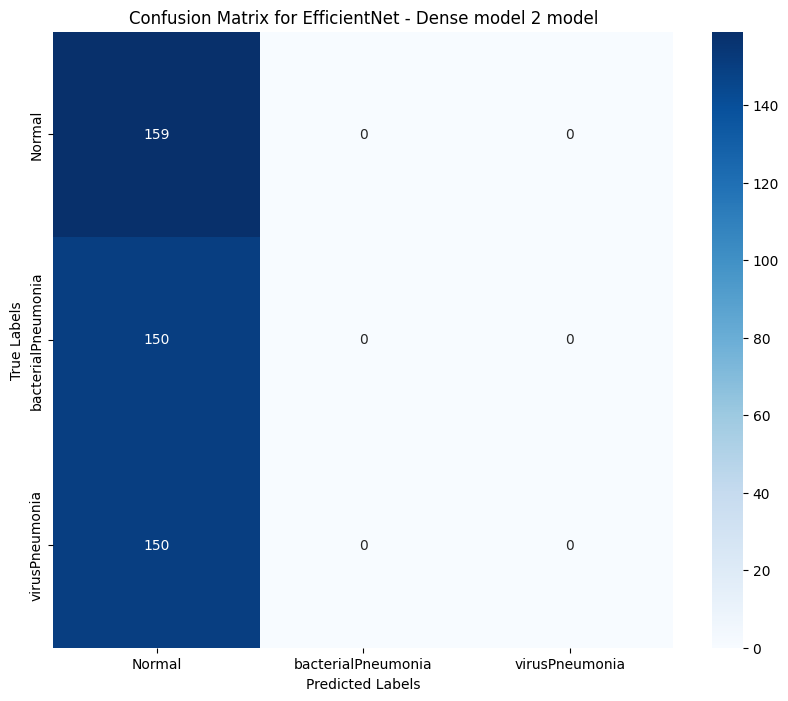


                    precision    recall  f1-score   support

            Normal       0.35      1.00      0.51       159
bacterialPneumonia       0.00      0.00      0.00       150
    virusPneumonia       0.00      0.00      0.00       150

          accuracy                           0.35       459
         macro avg       0.12      0.33      0.17       459
      weighted avg       0.12      0.35      0.18       459




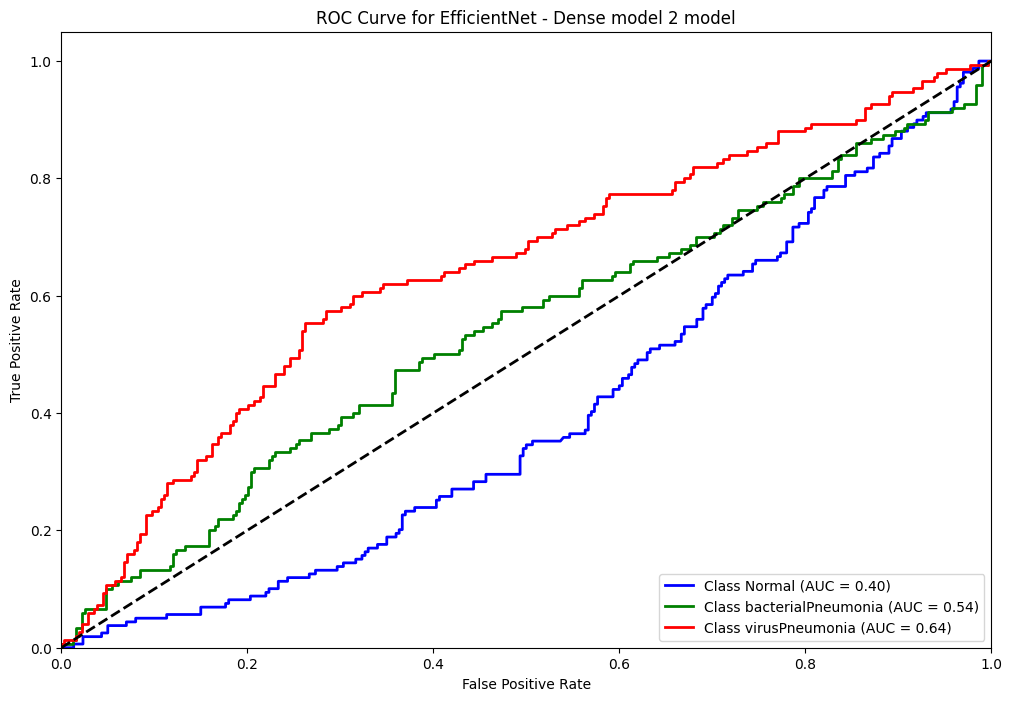

In [7]:
getModelTestResults(model,test_dataset,classNames,name="EfficientNet - Dense model 2")

### VGG16 con la primera configuración

In [ ]:
model = model_VGG16_v1.get_best_models()[0]
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 720, 500, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 22, 15, 512)    │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,312,459 (58.41 MB)

 Trainable params: 198,915 (777.01 KB)

 Non-trainable params: 14,715,712 (56.14 MB)

 Optimizer params: 397,832 (1.52 MB)

15/15 ━━━━━━━━━━━━━━━━━━━━ 636s 44s/step


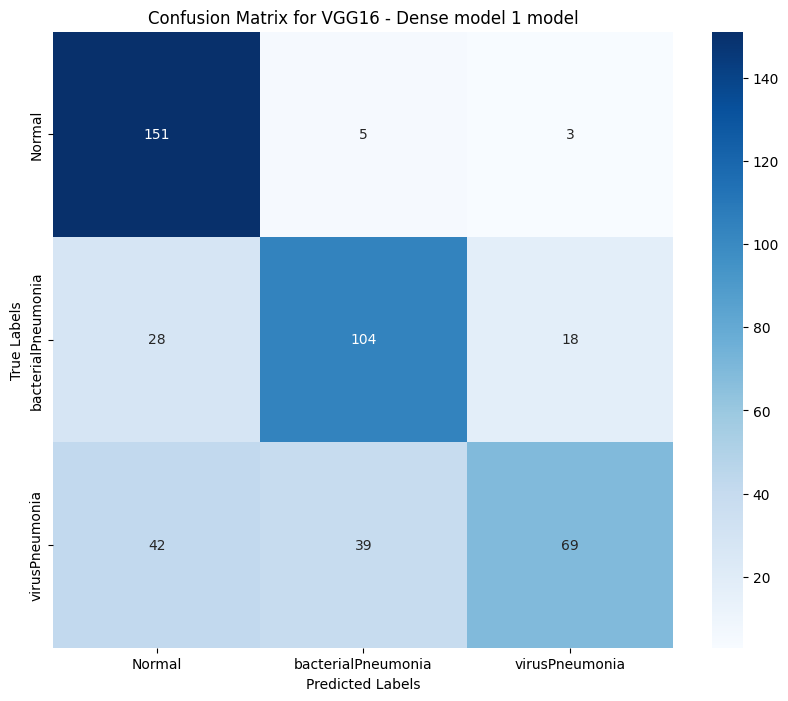


                    precision    recall  f1-score   support

            Normal       0.68      0.95      0.79       159
bacterialPneumonia       0.70      0.69      0.70       150
    virusPneumonia       0.77      0.46      0.57       150

          accuracy                           0.71       459
         macro avg       0.72      0.70      0.69       459
      weighted avg       0.72      0.71      0.69       459




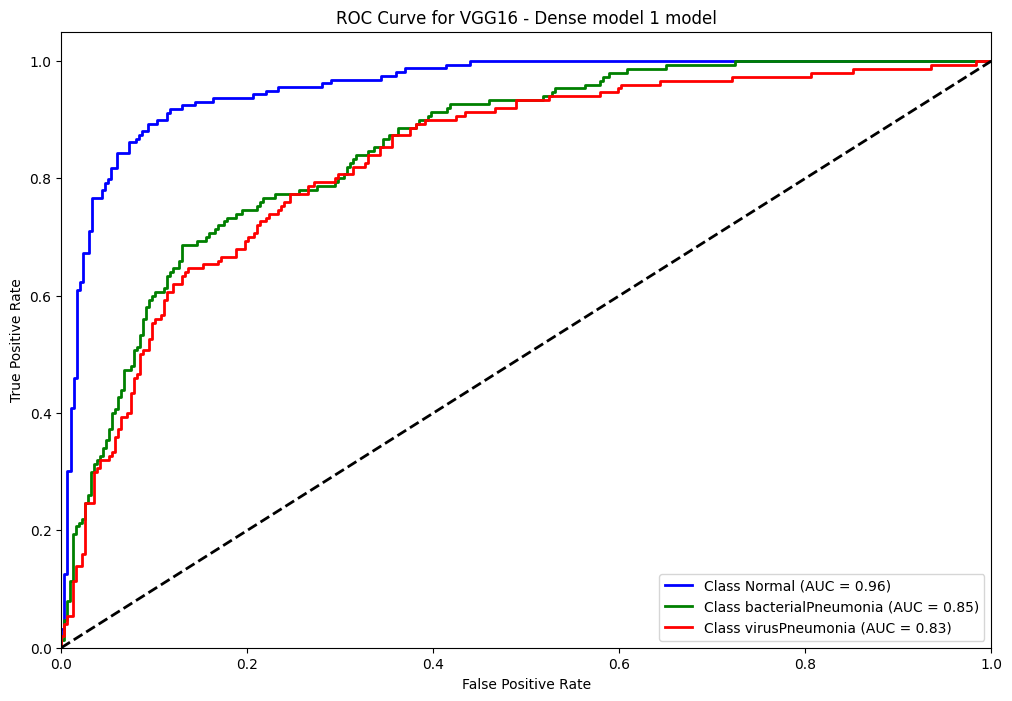

In [4]:
getModelTestResults(model,test_dataset,classNames,name="VGG16 - Dense model 1")

### VGG16 con la segunda configuración

In [3]:
model = tf.keras.models.load_model('modelvgg162keras.keras')
#model = model_VGG16_v2.get_best_models()[0]
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 720, 500, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 22, 15, 512)    │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,752,520 (56.28 MB)

 Trainable params: 18,819 (73.51 KB)

 Non-trainable params: 14,714,880 (56.13 MB)

 Optimizer params: 18,821 (73.52 KB)

15/15 ━━━━━━━━━━━━━━━━━━━━ 316s 19s/step


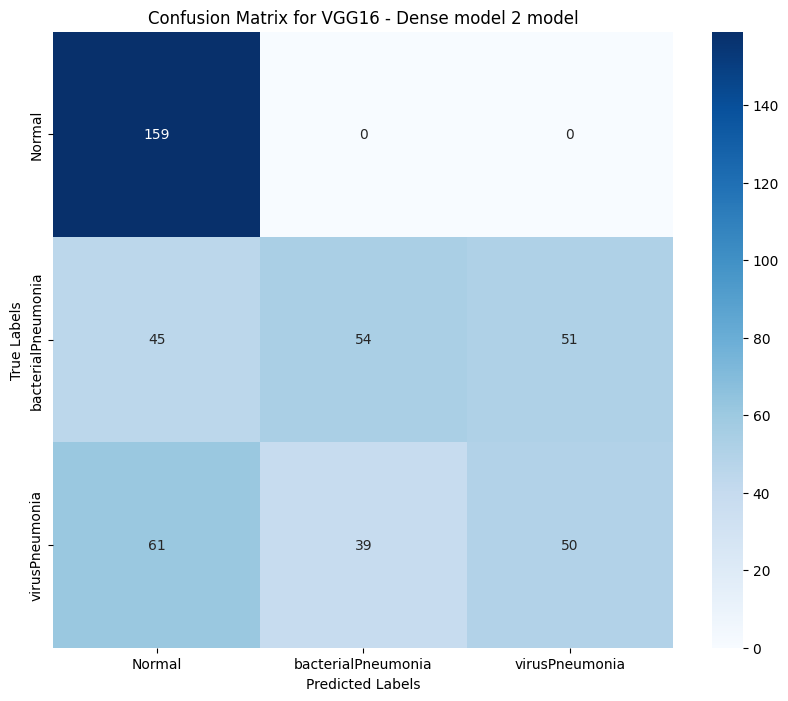


                    precision    recall  f1-score   support

            Normal       0.60      1.00      0.75       159
bacterialPneumonia       0.58      0.36      0.44       150
    virusPneumonia       0.50      0.33      0.40       150

          accuracy                           0.57       459
         macro avg       0.56      0.56      0.53       459
      weighted avg       0.56      0.57      0.54       459




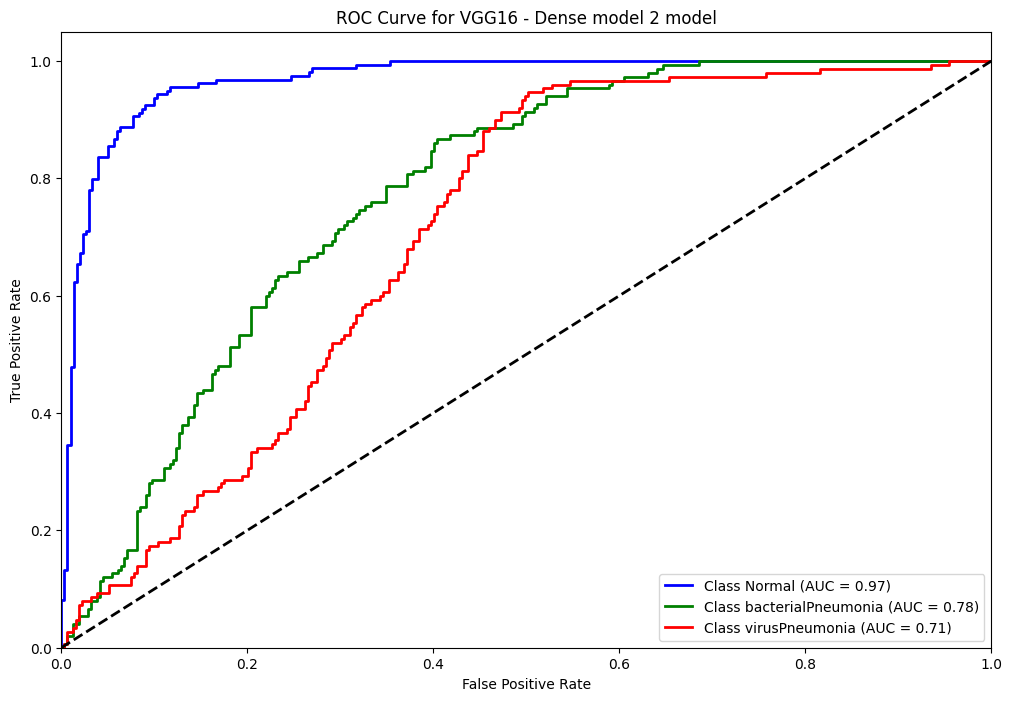

In [4]:
getModelTestResults(model,test_dataset,classNames,name="VGG16 - Dense model 2")

## Entrenamiento modelo final